In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import Preprocessing
import DataProcessing
import model
import numpy as np
import utils
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# load data 
data = Preprocessing.load_data('data/rt_iot2022', target_col='Attack_type')

c:\Users\QUIN\anaconda3\envs\PPNKCH\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Preprocessing.check_types(data,"object")

proto
service
Attack_type


In [3]:
attack_labels = data['Attack_type'].unique()

In [4]:
data = Preprocessing.delete_columns(data, ["Unnamed: 0",'service'])
data = data.loc[:, data.columns.notna()]
data = Preprocessing.one_hot_encode(data, ['proto'])
data,_ = Preprocessing.label_encode(data, ['Attack_type'])
print(data.head(5))

   id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
0      38667       1883      32.011598             9             5   
1      51143       1883      31.883584             9             5   
2      44761       1883      32.124053             9             5   
3      60893       1883      31.961063             9             5   
4      51087       1883      31.902362             9             5   

   fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  \
0                  3                  3          0.281148          0.156193   
1                  3                  3          0.282277          0.156821   
2                  3                  3          0.280164          0.155647   
3                  3                  3          0.281593          0.156440   
4                  3                  3          0.282111          0.156728   

   flow_pkts_per_sec  ...      idle.max      idle.tot      idle.avg  idle.std  \
0           0.437341  .

In [5]:
# Tìm các cột không phải là số (numeric)
non_numeric_cols = data.select_dtypes(exclude=["number"]).columns.tolist()
print("Các cột không phải kiểu số:")
print(non_numeric_cols)


Các cột không phải kiểu số:
['proto_tcp', 'proto_udp']


In [6]:
#Tách cột target ra khỏi dữ liệu
X, y = data.drop('Attack_type', axis=1), data['Attack_type']
X,_ = Preprocessing.scale_data(X)
# X_balanced, y_balanced = Preprocessing.apply_smote(X, y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [7]:
#chưa áp dụng smotesmote
X_train_nsm, X_test_nsm, y_train_nsm, y_test_nsm = train_test_split(X,y, test_size=0.2, random_state=42)

#áp dụng smote
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sm, y_train_sm = Preprocessing.apply_smote(X_train_sm, y_train_sm)

Train với dữ liệu chưa giảm chiều

xgboost

In [8]:
attack_labels = [
    'ARP_poisioning',
    'DDOS_Slowloris',
    'DOS_SYN_Hping',
    'MQTT_Publish',
    'Metasploit_Brute_Force_SSH',
    'NMAP_FIN_SCAN',
    'NMAP_OS_DETECTION',
    'NMAP_TCP_scan',
    'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN',
    'Thing_Speak',
    'Wipro_bulb'
]

In [9]:
print(y_test_sm.value_counts())

Attack_type
2     18897
10     1625
0      1578
3       871
8       489
6       393
9       384
7       220
1       100
11       58
4         6
5         3
Name: count, dtype: int64


Train với dữ liệu đã giảm chiều

c:\Users\QUIN\Desktop\DataMindning\DataProcessing.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


40


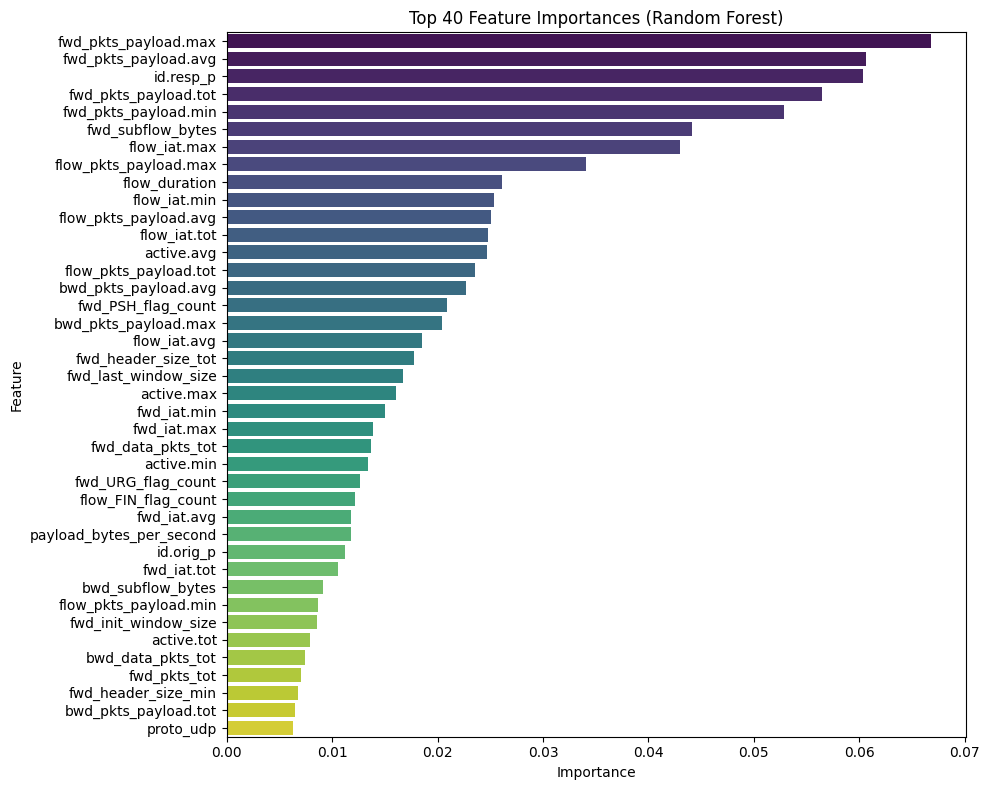

In [10]:
# Xử lý dữ liệu
list = DataProcessing.select_feature(X_train_sm, y_train_sm)
print(len(list))

In [11]:
X_train_sm = X_train_sm[list['Feature']]
df_reduced, dropped_columns = DataProcessing.remove_highly_correlated_columns(X_train_sm[list['Feature']], threshold=0.8)

Các cột bị loại bỏ: ['bwd_pkts_payload.max', 'bwd_pkts_payload.avg', 'active.max', 'flow_pkts_payload.max', 'fwd_iat.tot', 'flow_iat.tot', 'bwd_data_pkts_tot', 'bwd_pkts_payload.tot', 'fwd_iat.avg', 'active.min', 'fwd_pkts_payload.min', 'fwd_iat.max', 'fwd_pkts_tot', 'flow_iat.avg', 'bwd_subflow_bytes', 'fwd_data_pkts_tot']


In [12]:
X_train_sm_dr = df_reduced
X_test_sm_dr = X_test_sm[list['Feature']].drop(dropped_columns, axis=1)
y_train_sm_dr = y_train_sm.copy()
y_test_sm_dr = y_test_sm.copy()

xgboost

c:\Users\QUIN\anaconda3\envs\PPNKCH\lib\site-packages\xgboost\training.py:183: UserWarning: [06:50:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thời gian chạy: 1.8741 giây
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1578
           1       0.98      1.00      0.99       100
           2       1.00      1.00      1.00     18897
           3       1.00      1.00      1.00       871
           4       0.83      0.83      0.83         6
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00       393
           7       1.00      1.00      1.00       220
           8       0.99      0.98      0.99       489
           9       1.00      0.99      1.00       384
          10       0.99      0.99      0.99      1625
          11       1.00      0.97      0.98        58

    accuracy                           1.00     24624
   macro avg       0.98      0.95      0.96     24624
weighted avg       1.00      1.00      1.00     24624

Confusion Matrix:
 [[ 1568     0     0     0     0     0     0     0     1     0 

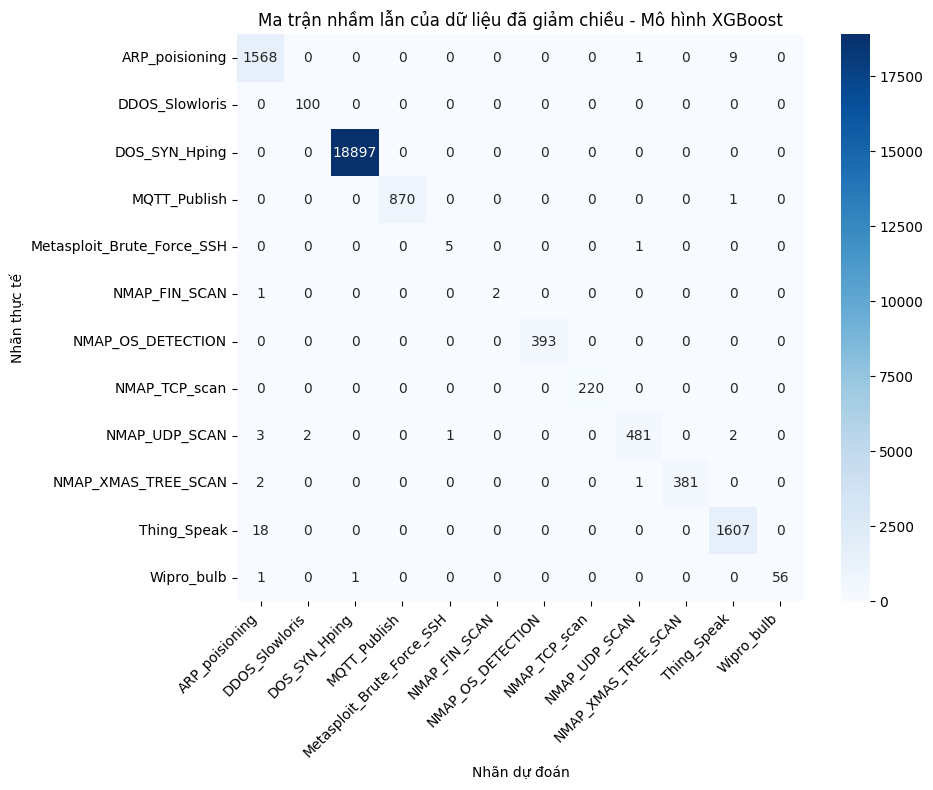

In [13]:
model_xgboost_dr = model.model_xgboost(X_train_sm_dr, y_train_sm_dr,12)
y_pred_dr = model_xgboost_dr.predict(X_test_sm_dr)
utils.report(y_test_sm_dr,y_pred_dr)
utils.plot_confusion_matrix(y_test_sm_dr,y_pred_dr, attack_labels, "Ma trận nhầm lẫn của dữ liệu đã giảm chiều - Mô hình XGBoost" )

In [14]:
accuracy = accuracy_score(y_test_sm_dr,y_pred_dr)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr,y_pred_dr, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])

Accuracy: 0.9982131254061078
Precision (macro): 0.9820307154141134
Recall (macro): 0.9518985549051299
F1-score (macro): 0.9641479552173059
Support (macro): 24624.0


In [15]:
utils.save_model(model_xgboost_dr, "model_xgboost_dr.pkl")

Model saved successfully to model/ model_xgboost_dr.pkl


random_forest

Thời gian chạy: 3.5426 giây
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1578
           1       0.99      0.98      0.98       100
           2       1.00      1.00      1.00     18897
           3       1.00      1.00      1.00       871
           4       0.83      0.83      0.83         6
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00       393
           7       1.00      1.00      1.00       220
           8       0.99      0.99      0.99       489
           9       1.00      0.99      1.00       384
          10       1.00      0.99      0.99      1625
          11       0.98      0.95      0.96        58

    accuracy                           1.00     24624
   macro avg       0.98      0.95      0.96     24624
weighted avg       1.00      1.00      1.00     24624

Confusion Matrix:
 [[ 1570     0     0     0     0     0     0     0     1     0 

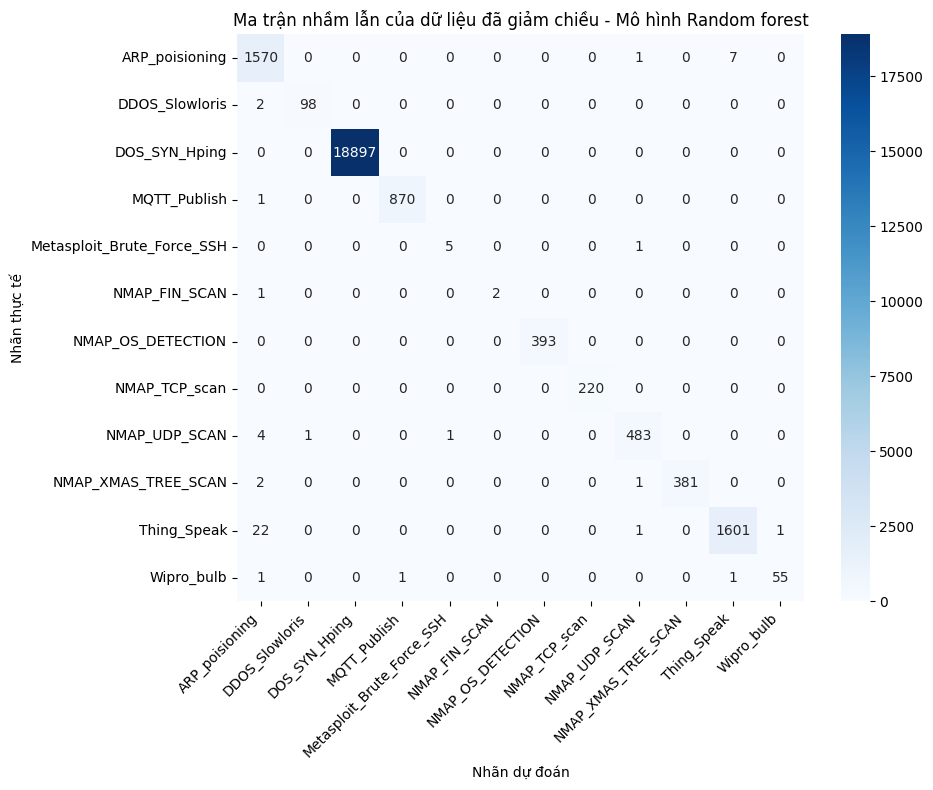

In [16]:
model_random_forest_dr = model.model_random_forest(X_train_sm_dr, y_train_sm_dr)
y_pred_dr = model_random_forest_dr.predict(X_test_sm_dr)
utils.report(y_test_sm_dr, y_pred_dr)
utils.plot_confusion_matrix(y_test_sm_dr, y_pred_dr, attack_labels, "Ma trận nhầm lẫn của dữ liệu đã giảm chiều - Mô hình Random forest" )

In [17]:
accuracy = accuracy_score(y_test_sm_dr, y_pred_dr)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr, y_pred_dr, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])

Accuracy: 0.9980100714749838
Precision (macro): 0.9808712574642326
Recall (macro): 0.9489338648776625
F1-score (macro): 0.9620892304677561
Support (macro): 24624.0


In [18]:
utils.save_model(model_random_forest_dr, "model_random_forest_dr.pkl")

Model saved successfully to model/ model_random_forest_dr.pkl


MLP

In [19]:
accuracy = accuracy_score(y_test_sm, y_pred_dr)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm, y_pred_dr, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])

Accuracy: 0.9980100714749838
Precision (macro): 0.9808712574642326
Recall (macro): 0.9489338648776625
F1-score (macro): 0.9620892304677561
Support (macro): 24624.0


Train mô hỉnh tinh chỉnh.

In [20]:

# y_pred = model_random_forest.predict(X_test_sm)
# utils.report(y_pred,y_test_sm)

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

Random Forest

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Thời gian huấn luyện: 246.76 giây
Best params: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
Random Forest Classification Report:
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1578
           1       0.98      0.98      0.98       100
           2       1.00      1.00      1.00     18897
           3       1.00      1.00      1.00       871
           4       1.00      0.67      0.80         6
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00       393
           7       1.00      1.00      1.00       220
           8       0.99      0.99      0.99       489
           9       1.00      0.99      1.00       384
          10       0.99      0.99      0.99      1625
          11       0.98      0.95      0.96        

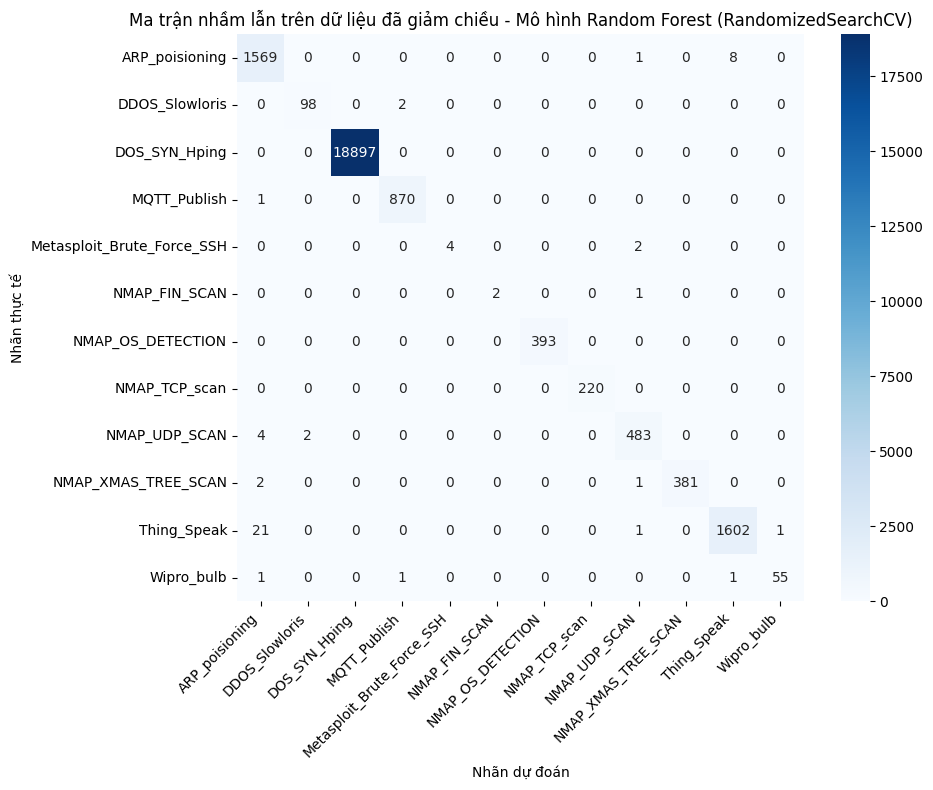

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import time

# Không gian tham số mở rộng
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Khởi tạo mô hình Random Forest
get_random_forest_model_instance = model.get_random_forest_model() 

# Tìm kiếm tham số ngẫu nhiên
random_search = RandomizedSearchCV(
    estimator=get_random_forest_model_instance,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Huấn luyện và đo thời gian
start_time = time.time()
random_search.fit(X_train_sm_dr, y_train_sm_dr)
end_time = time.time()
print(f'Thời gian huấn luyện: {end_time - start_time:.2f} giây')

# Kết quả
print("Best params:", random_search.best_params_)

# Dự đoán và đánh giá
y_pred_rd = random_search.predict(X_test_sm_dr)
print("Random Forest Classification Report:")
utils.report(y_test_sm_dr, y_pred_rd)

utils.plot_confusion_matrix(
    y_test_sm_dr,
    y_pred_rd,
    attack_labels,
    "Ma trận nhầm lẫn trên dữ liệu đã giảm chiều - Mô hình Random Forest (RandomizedSearchCV)"
)


In [23]:
accuracy = accuracy_score(y_test_sm_dr,y_pred_rd)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr,y_pred_rd, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])

Accuracy: 0.9979694606887589
Precision (macro): 0.993558517965932
Recall (macro): 0.9350434485765997
F1-score (macro): 0.9587144756984046
Support (macro): 24624.0


XGBoost

Class distribution: Counter({2: 75762, 10: 6483, 0: 6172, 3: 3275, 8: 2101, 9: 1626, 6: 1607, 7: 782, 11: 500, 1: 500, 4: 500, 5: 500})
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\QUIN\anaconda3\envs\PPNKCH\lib\site-packages\xgboost\training.py:183: UserWarning: [07:01:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thời gian huấn luyện: 364.21 giây
Best parameters for XGBoost: {'subsample': 0.6, 'scale_pos_weight': np.float64(12.344), 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}
XGBoost Classification Report:
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1578
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00     18897
           3       1.00      1.00      1.00       871
           4       0.67      0.67      0.67         6
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00       393
           7       1.00      1.00      1.00       220
           8       0.99      0.99      0.99       489
           9       1.00      0.99      1.00       384
          10       0.99      0.99      0.99      1625
          11       1.00      0.95      0.97        58

    accuracy         

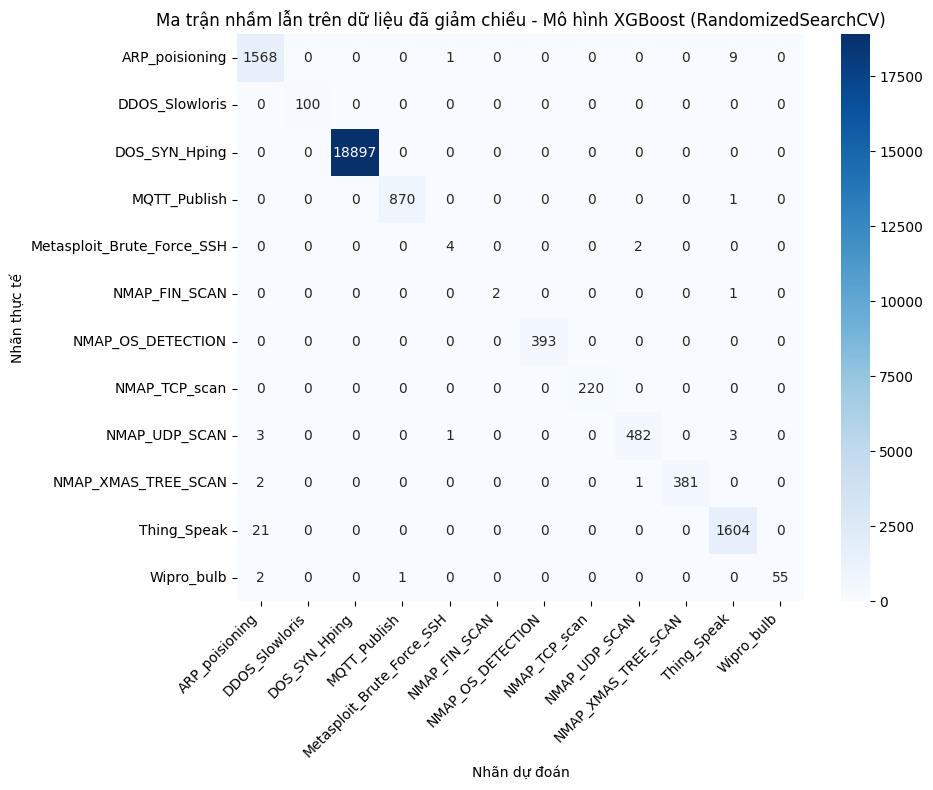

In [24]:
from sklearn.model_selection import GridSearchCV
import time
from collections import Counter
# Kiểm tra phân bố lớp
print("Class distribution:", Counter(y_train_sm_dr))

# Tính scale_pos_weight
class_counts = np.bincount(y_train_sm_dr)
scale_pos_weight = float(class_counts[0]) / class_counts[1]

# Không gian tham số mở rộng
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1.0, scale_pos_weight],
    'gamma': [0, 0.1, 0.2]  # tuỳ chọn
}

# Khởi tạo mô hình
xgb_model = model.get_xgboost_model(random_state=42)

# Tìm kiếm ngẫu nhiên
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # tăng nếu có thể
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
start_time = time.time()
random_search_xgb.fit(X_train_sm_dr, y_train_sm_dr)
end_time = time.time()
print(f'Thời gian huấn luyện: {end_time - start_time:.2f} giây')

# Mô hình tốt nhất
best_xgb_model = random_search_xgb.best_estimator_
print("Best parameters for XGBoost:", random_search_xgb.best_params_)

# Đánh giá
y_pred_xgb = best_xgb_model.predict(X_test_sm_dr)
print("XGBoost Classification Report:")
utils.report(y_test_sm_dr, y_pred_xgb)
utils.plot_confusion_matrix(
    y_test_sm_dr,
    y_pred_xgb,
    attack_labels,
    "Ma trận nhầm lẫn trên dữ liệu đã giảm chiều - Mô hình XGBoost (RandomizedSearchCV)"
)


In [25]:
accuracy = accuracy_score(y_test_sm_dr, y_pred_xgb)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr, y_pred_xgb, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])

Accuracy: 0.9980506822612085
Precision (macro): 0.9694280397316283
Recall (macro): 0.936589454067787
F1-score (macro): 0.9501680523800674
Support (macro): 24624.0


KNN

In [ ]:
# Định nghĩa không gian tham số cho KNN
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Khởi tạo mô hình
knn_model = model.get_knn_model()

# Tìm kiếm ngẫu nhiên
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)

# Huấn luyện
start_time = time.time()
random_search_knn.fit(X_train_sm_dr, y_train_sm_dr)
end_time = time.time()
print(f'Thời gian huấn luyện: {end_time - start_time:.2f} giây')
# Lấy mô hình tốt nhất
best_knn_model = random_search_knn.best_estimator_
print("Best parameters for KNN:", random_search_knn.best_params_)

# Dự đoán và đánh giá
y_pred_knn = best_knn_model.predict(X_test_sm_dr)
print("KNN Classification Report:")
utils.report(y_test_sm_dr, y_pred_knn)
utils.plot_confusion_matrix(y_test_sm_dr, y_pred_knn, attack_labels, "Ma trận nhầm lẫn trên dữ liệu đã giảm chiều - Mô hình KNN (RandomizedSearchCV)" )

In [ ]:
accuracy = accuracy_score(y_test_sm_dr, y_pred_knn)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr, y_pred_knn, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])


GridSearchCV

get_random_forest_model

In [ ]:
# Không gian tham số cho GridSearchCV (thu hẹp để tối ưu thời gian)
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Thử 4 giá trị
    'max_depth': [3, 10, 20, None],      # Thử 3 giá trị + None
    'min_samples_split': [2, 5, 10],     # Thử 3 giá trị
    'min_samples_leaf': [1, 5, 10],      # Thử 3 giá trị
    'max_features': ['sqrt', 'log2', None],  # Giữ nguyên
    'bootstrap': [True, False]           # Giữ nguyên
}

# Khởi tạo mô hình Random Forest
get_random_forest_model_instance = model.get_random_forest_model(random_state=42)

# Tìm kiếm tham số với GridSearchCV
grid_search = GridSearchCV(
    estimator=get_random_forest_model_instance,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện và đo thời gian
start_time = time.time()
grid_search.fit(X_train_sm_dr, y_train_sm_dr)
end_time = time.time()
print(f'Thời gian huấn luyện: {end_time - start_time:.2f} giây')

# Kết quả
print("Best params:", grid_search.best_params_)

# Dự đoán và đánh giá
y_pred_rd = grid_search.predict(X_test_sm_dr)
print("Random Forest Classification Report:")
utils.report(y_test_sm_dr, y_pred_rd)

utils.plot_confusion_matrix(
    y_test_sm_dr,
    y_pred_rd,
    attack_labels,
    "Ma trận nhầm lẫn trên dữ liệu đã giảm chiều - Mô hình Random Forest (GridSearchCV)"
)

In [ ]:
accuracy = accuracy_score(y_test_sm_dr,y_pred_rd)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr,y_pred_rd, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])

get_xgboost_model

In [ ]:
# Kiểm tra phân bố lớp
print("Class distribution:", Counter(y_train_sm_dr))

# Tính scale_pos_weight
class_counts = np.bincount(y_train_sm_dr)
scale_pos_weight = float(class_counts[0]) / class_counts[1]

# Không gian tham số
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1.0, scale_pos_weight],
    'gamma': [0, 0.1, 0.2]
}

# Khởi tạo mô hình
xgb_model = model.get_xgboost_model(random_state=42)

# Tìm kiếm tham số với GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
start_time = time.time()
grid_search_xgb.fit(X_train_sm_dr, y_train_sm_dr)
end_time = time.time()
print(f'Thời gian huấn luyện: {end_time - start_time:.2f} giây')

# Mô hình tốt nhất
best_xgb_model = grid_search_xgb.best_estimator_
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Đánh giá
y_pred_xgb = best_xgb_model.predict(X_test_sm_dr)
print("XGBoost Classification Report:")
utils.report(y_test_sm_dr, y_pred_xgb)
utils.plot_confusion_matrix(
    y_test_sm_dr,
    y_pred_xgb,
    attack_labels,
    "Ma trận nhầm lẫn trên dữ liệu đã giảm chiều - Mô hình XGBoost (GridSearchCV)"
)

In [ ]:
accuracy = accuracy_score(y_test_sm_dr, y_pred_xgb)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr, y_pred_xgb, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])

KNN

In [ ]:
# Định nghĩa không gian tham số cho KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Khởi tạo mô hình
knn_model = model.get_knn_model()

# Tìm kiếm tham số với GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid_knn,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
start_time = time.time()
grid_search_knn.fit(X_train_sm_dr, y_train_sm_dr)
end_time = time.time()
print(f'Thời gian huấn luyện: {end_time - start_time:.2f} giây')

# Lấy mô hình tốt nhất
best_knn_model = grid_search_knn.best_estimator_
print("Best parameters for KNN:", grid_search_knn.best_params_)

# Dự đoán và đánh giá
y_pred_knn = best_knn_model.predict(X_test_sm_dr)
print("KNN Classification Report:")
utils.report(y_test_sm_dr, y_pred_knn)
utils.plot_confusion_matrix(
    y_test_sm_dr,
    y_pred_knn,
    attack_labels,
    "Ma trận nhầm lẫn trên dữ liệu đã giảm chiều - Mô hình KNN (GridSearchCV)"
)

In [ ]:
accuracy = accuracy_score(y_test_sm_dr, y_pred_knn)
print("Accuracy:", accuracy)

report = classification_report(y_test_sm_dr, y_pred_knn, output_dict=True)
print("Precision (macro):", report["macro avg"]["precision"])
print("Recall (macro):", report["macro avg"]["recall"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("Support (macro):", report["macro avg"]["support"])
